# Implementing MDS in the Poincaré Disk
`Drew Wilimitis`

My approach will primarily follow the general algorithmic outline discussed by A. Cvetkovski and M. Crovellain in **[1]**. As far as I am aware there aren't any released implementations of this Poincaré Disk MDS algorithm, although there was a very recent release of a PyTorch implementation of Hyperbolic MDS that seems to use a modified Principal Component Analysis as well as the hyperboloid model of hyperbolic space, which is discussed in **[3]**. <br>
<br>
I implement this hyperbolic MDS algorithm with Numpy and try to base some general aspects of the implementation structure on the design of Multidimensional Scaling from the `sklearn.manifold` library. In the final section I test my hMDS model on some sample datasets and compare the results to those provided in **[1]**.

In [751]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from sklearn.metrics import euclidean_distances
import time
from sklearn.decomposition import PCA
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [753]:
# define helper functions
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

# convert array or list [a, b] to complex number a+bi
def to_complex(xi):
    return np.complex(xi[0], xi[1])
to_complex([1,1])
np.complex(1+1j)*np.complex(1-1j)
np.conj(1+1j)
np.complex(1,1)
norm(np.complex(0.7,0.7))

# initialize embedding configuration
def init_z(n, dim=2, low=-0.5, high=0.5, complex_num = True):
    random_config = np.random.uniform(low, high, size=(n, dim))
    z_config = np.array([to_complex(x) for x in random_config])
    if complex_num:
        return z_config
    else:
        return random_config
    
def generate_data(n, radius=0.3):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

# optionally clip data points within disk boundary
def proj(theta, eps=1e-2):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

(1+1j)

(2+0j)

(1-1j)

(1+1j)

0.9899494936611665

## Loss function and Gradients

In [233]:
# alternate poincare distance formula with complex numbers
def poincare_dist(zi, zj):
    if not isinstance(zi,complex):
        zi = to_complex(zi)
    if not isinstance(zj,complex):
        zj = to_complex(zj)
    return 2*np.arctanh(norm(zi - zj) / norm(1 - zi*np.conj(zj)))

# compute symmetric poincare distance matrix
def pd_matrix(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# partial derivative of poincare distance
def partial_d(xi, xj):
    if not isinstance(xi,complex):
        xi = to_complex(xi)
    if not isinstance(xj,complex):
        xj = to_complex(xj)
    v1 = np.real(xi) - np.real(xj)
    v2 = np.imag(xi) - np.imag(xj)
    v3 = np.real(xi)*np.real(xj) + np.imag(xi)*np.imag(xj) - 1
    v4 = np.real(xi)*np.imag(xj) - np.real(xj)*np.imag(xi)
    t = np.sqrt((v1**2 + v2**2) / (v3**2 + v4**2))
    dxi_1 = 2*t / (1 - t**2) * (v1 / (v1**2 + v2**2) - (np.real(xj)*v3 + np.imag(xj)*v4) / (v3**2 + v4**2))
    dxi_2 = 2*t / (1 - t**2) * (v2 / (v1**2 + v2**2) - (np.real(xi)*v4 - np.imag(xj)*v3) / (v3**2 + v4**2))
    return np.array([dxi_1, dxi_2])
partial_d(np.complex(0.5, 0.5), np.complex(0.49, 0.49))

array([2.82842712, 2.72177616])

In [201]:
def compute_gradients(Z, dissimilarities, alpha=1):
    n = Z.shape[0]
    gradients = np.zeros((n, 2))
    for i in range(n):
        grad_zi = 0
        for j in range(i+1, n):
            dd_loss = 2*poincare_dist(Z[i], Z[j]) - 2*alpha*dissimilarities[i][j]
            dd_dist = partial_d(Z[i], Z[j])
            grad_zi += dd_loss * dd_dist
        if norm(grad_zi) > 1:
            grad_zi = grad_zi / norm(grad_zi)
        gradients[i] = grad_zi
    return gradients

def loss_fn(embed_config, dissimilarities, alpha=1):
    n = dissimilarities.shape[0]
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss

## Hyperbolic Line Search

In [291]:
def step_error(r, Z, g, dissimilarities, n=None):
    if n == None:
        n = dissimilarities.shape[0]
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    M_r = []
    for j in range(n):
        M_r.append((-r*g[j] + Z[j]) / (-r*g[j] * np.conj(Z[j]) + 1))
    return loss_fn(np.array(M_r), dissimilarities)

In [343]:
# approximate hyperbolic line search
def line_search(Z, dissimilarities, g, n, r0, rmax, verbose=False):
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    Z_norm = np.array([norm(z)**2 for z in Z])
    M_prime = g*Z_norm
    qprime_0 = np.dot(np.real(M_prime).T, np.real(g)) + np.dot(np.imag(M_prime).T, np.imag(g))
    p = 0.5
    r = r0
    q0 = step_error(0, Z, g, dissimilarities, n)
    roof_fn = lambda r: q0 + p*qprime_0*r
    rmin = 1e-10
    while r < rmax and step_error(r, Z, g, dissimilarities, n) < roof_fn(r):
        if verbose:
            print('step size: ',r)
            print('roof fn: ', roof_fn(r))
            print('step error: ', step_error(r, Z, g, dissimilarities, n))
        r = 2*r
    while r > rmax or step_error(r, Z, g, dissimilarities, n) > roof_fn(r):
        if verbose:
            print('step size: ',r)
            print('roof fn: ', roof_fn(r))
            print('step error: ', step_error(r, Z, g, dissimilarities, n))
        if r < rmin:
            return 2*r
        r = r/2
    return r
line_search(z_config, delta, init_g, delta.shape[0], 0.01, 0.5, verbose=True)

step size:  0.01
roof fn:  7.908121828722486
step error:  7.573255269480804
step size:  0.02
roof fn:  7.910011318403563
step error:  7.252322626968635
step size:  0.04
roof fn:  7.9137902977657175
step error:  6.645754845381659
step size:  0.08
roof fn:  7.921348256490027
step error:  5.568365472524534
step size:  0.16
roof fn:  7.936464173938645
step error:  3.9148810484604386
step size:  0.32
roof fn:  7.96669600883588
step error:  2.1772111962277245
step size:  0.64
roof fn:  8.027159678630353
step error:  6.61110312731831


0.32

## HyperMDS

In [661]:
class HyperMDS():
    
    def __init__(self, dim=2, max_iter=3, verbose=0, eps=1e-5, alpha=1, save_metrics=False,
                 random_state=None, dissimilarity="euclidean"):
        self.dim = dim
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.alpha = alpha
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state
        self.save_metrics = save_metrics
        if self.save_metrics:
            self.gradient_norms = []
            self.steps = []
            self.rel_steps = []
            self.losses = []
        
    def init_embed(self, low=-0.2, high=0.2, complex_num=True):
        random_config = np.random.uniform(low, high, size=(self.n, self.dim))
        c_config = np.array([to_complex(x) for x in random_config], dtype=np.complex_)
        if complex_num:
            self.embedding = c_config
        else:
            self.embedding = random_config
    
    def loss_fn(self):
        loss = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                d_ij = poincare_dist(self.embedding[i], self.embedding[j])
                delta_ij = self.alpha*self.dissimilarity_matrix[i][j]
                loss += (d_ij - delta_ij)**2
        self.loss = loss

    def compute_gradients(self):
        gradients = np.zeros((self.n, 2))
        for i in range(self.n):
            grad_zi = 0
            for j in range(i+1, self.n):
                delta_ij = self.alpha*self.dissimilarity_matrix[i][j]
                dd_ij = 2*poincare_dist(self.embedding[i], self.embedding[j])
                ddelta_ij = 2*delta_ij
                dd_loss = dd_ij - ddelta_ij
                dd_dist = partial_d(self.embedding[i], self.embedding[j])
                weight_ij = 2 / (self.n * (self.n - 1)) #* 1/(delta_ij**2)
                grad_zi += dd_loss * dd_dist * weight_ij
            #if norm(grad_zi) > 1:
            #    grad_zi = grad_zi / norm(grad_zi)
            gradients[i] = grad_zi
        self.gradients = gradients
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, init=None, init_low=-0.2, init_high=0.2, 
                      max_epochs = 40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        init_low: lower bound for range of initial configuration
        init_high: upper bound for range of initial configuration
        max_epochs: maximum number of gradient descent iterations
        verbose: optionally print training scores
        """
        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix = euclidean_distances(X)
        elif self.dissimilarity == 'hyperbolic':
            self.dissimilarity_matrix = pd_matrix(X)
        self.n = self.dissimilarity_matrix.shape[0]
        
        # use pca as initial config
        if init == 'pca':
            pca = PCA(n_components=2)
            X_proj = pca.fit_transform(X)
            X_proj = X_proj / norm(X_proj)
            self.embedding = X_proj
        else:
            self.init_embed(low=init_low, high=init_high)
        
        # set a max distance window for embedding
        smax = 10
        prev_loss = np.inf
        for i in range(max_epochs):
            # break if loss decrease < tolerance
            self.loss_fn()
            if (prev_loss - self.loss) / prev_loss < 0.0001:
                break
            prev_loss = self.loss
            self.compute_gradients()
            # set max step size and perform line search
            rmax = 1/(norm(self.gradients, axis=1).max() +self.eps) * np.tanh(smax/2)
            r = line_search(self.embedding, self.dissimilarity_matrix, self.gradients,
                            self.n, 1, rmax)
            if r < 1e-8:
                break
            # update each zi
            for j in range(self.n):
                zi_num = -r*to_complex(self.gradients[j]) + self.embedding[j]
                zi_denom = -r*to_complex(self.gradients[j]) * np.conj(self.embedding[j]) + 1
                zi_prime = zi_num / zi_denom
                self.embedding[j] = zi_prime
            # optionally save training metrics
            if self.save_metrics:
                self.gradient_norms.append(norm(self.gradients, axis=1).max())
                self.steps.append(r)
                self.rel_steps.append(r/rmax)
                self.losses.append(self.loss)
            if verbose:
                print('Epoch ' + str(i+1) + ' complete')
                print('Loss: ', self.loss)
                print('\n')
                
        # final loss value
        self.loss_fn()
        # remove complex numbers in embedding
        final_emb = self.embedding.reshape(-1,1)
        self.embedding = np.hstack((np.real(final_emb), np.imag(final_emb)))
        return self.embedding

In [662]:
# compute poincaré distance matrix
def pd_matrix(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# compute Sammon stress of the embedding
def sammon_stress(embedding, dissimilarity_matrix, alpha=1):
    stress = 0
    scale = 0
    n = embedding.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if dissimilarity_matrix[i][j] != 0:
                delta_ij = alpha * dissimilarity_matrix[i][j]
                d_ij = poincare_dist(embedding[i], embedding[j])
                scale += delta_ij
                stress += (d_ij - delta_ij)**2 / delta_ij
    return stress/scale

## Evaluating Test Results

In [711]:
import seaborn as sns
def plot_errors(model, input_data, title = 'Embedding Errors', num_rounds = 20):
    results = []
    for i in range(num_rounds):
        embed = model.fit_transform(input_data)
        stress = sammon_stress(embed, model.dissimilarity_matrix)
        results.append(stress)
    plt.figure(figsize=(7,5))
    plt.scatter(x=np.arange(0, len(results), 1), y=np.sort(results))
    plt.ylabel('Stress')
    plt.xlabel('hMDS Ranks')
    plt.title(title)
    plt.show()
    print('Min Error: ', np.min(results))
    print('Mean Error: ', np.mean(results))
    print('Std. Deviation of Error: ', np.std(results))
    
def plot_alpha(model, input_data, title = 'Hyperbolic Scale Factor'):
    results = []
    alpha_range = np.arange(0.5, 10, 0.5)
    for alpha in alpha_range:
        model = HyperMDS(alpha = alpha)
        embed = model.fit_transform(input_data)
        stress = sammon_stress(embed, model.dissimilarity_matrix, alpha=alpha)
        results.append(stress)
    plt.figure(figsize=(7,5))
    plt.scatter(x=alpha_range, y=results)
    plt.ylabel('Stress')
    plt.xlabel('Scale factor alpha')
    plt.title(title)
    plt.show();
    
def plot_training_metrics(input_data, title = 'Metrics at Each Iteration'):
    model = HyperMDS(save_metrics = True)
    embed = model.fit_transform(input_data, max_epochs=20)
    fig = plt.figure(constrained_layout=True, figsize=(20, 15))
    spec = plt.GridSpec(ncols=2, nrows=2, figure=fig)
    n = len(model.losses)
    metrics = [model.losses, model.gradient_norms, model.steps, model.rel_steps]
    names = ['Error', 'Gradient Norm', 'Step Size', 'Rel. Step Size (r/rmax)']
    for i in range(4):
        ax = fig.add_subplot(spec[i])
        ax.scatter(np.arange(0, n, 1), metrics[i], s=60)
        ax.set_title(names[i], size=28)
        ax.tick_params(axis='both', which='major', labelsize=20)
    plt.suptitle(title, size=36)

### Ex 1.) Seven point sample

The first dataset used to test this implementation of Hyperbolic MDS is a simple random sample of seven data points in the poincaré disk, and we use the hyperbolic distances as our input dissimilarities to hMDS. Starting from a different random embedding configuration, hMDS is able to fit a very low stress embedding.

In [693]:
data = generate_data(7)
hmds = HyperMDS(dissimilarity='hyperbolic', alpha=1)
emb = hmds.fit_transform(data, max_epochs=30)
print('Sammon Stress: ', sammon_stress(emb, hmds.dissimilarity_matrix, alpha=1))

Sammon Stress:  0.004703303803714057


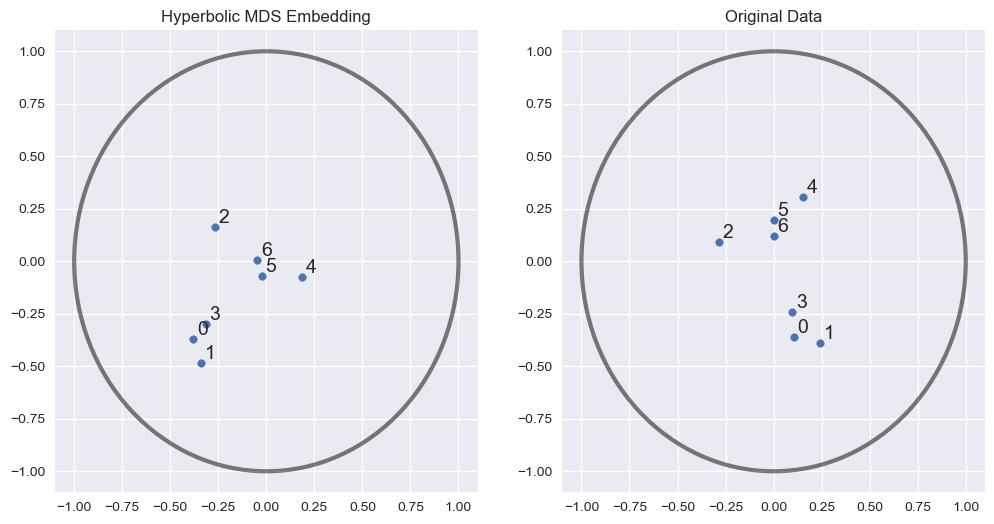

In [697]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = emb[:,0]
y = emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(emb)):
    ax.text(x[i]+0.02, y[i]+0.02, str(i), size=14)
ax.set_title('Hyperbolic MDS Embedding')
    
ax2 = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax2.add_patch(circ)

x = data[:,0]
y = data[:,1]
ax2.scatter(x, y, s=30, alpha=1)
for i in range(len(data)):
    ax2.text(x[i]+0.02, y[i]+0.02, str(i), size=14);
ax2.set_title('Original Data')
plt.show();

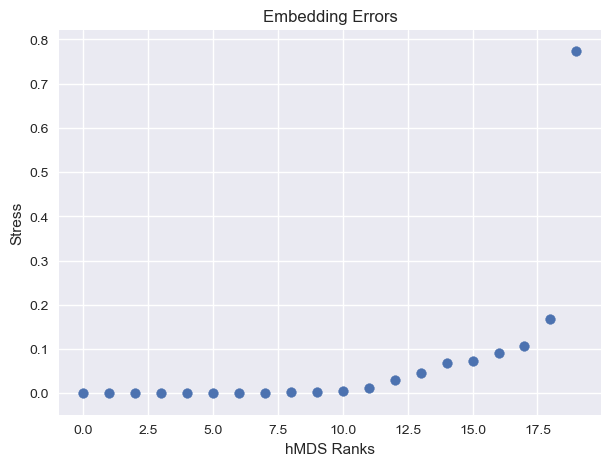

Min Error:  0.0003328392899980766
Mean Error:  0.06945360438719969
Std. Deviation of Error:  0.16780204822841968


In [698]:
data = generate_data(7)
hmds = HyperMDS(dissimilarity='hyperbolic', alpha=1)
plot_errors(hmds, data)

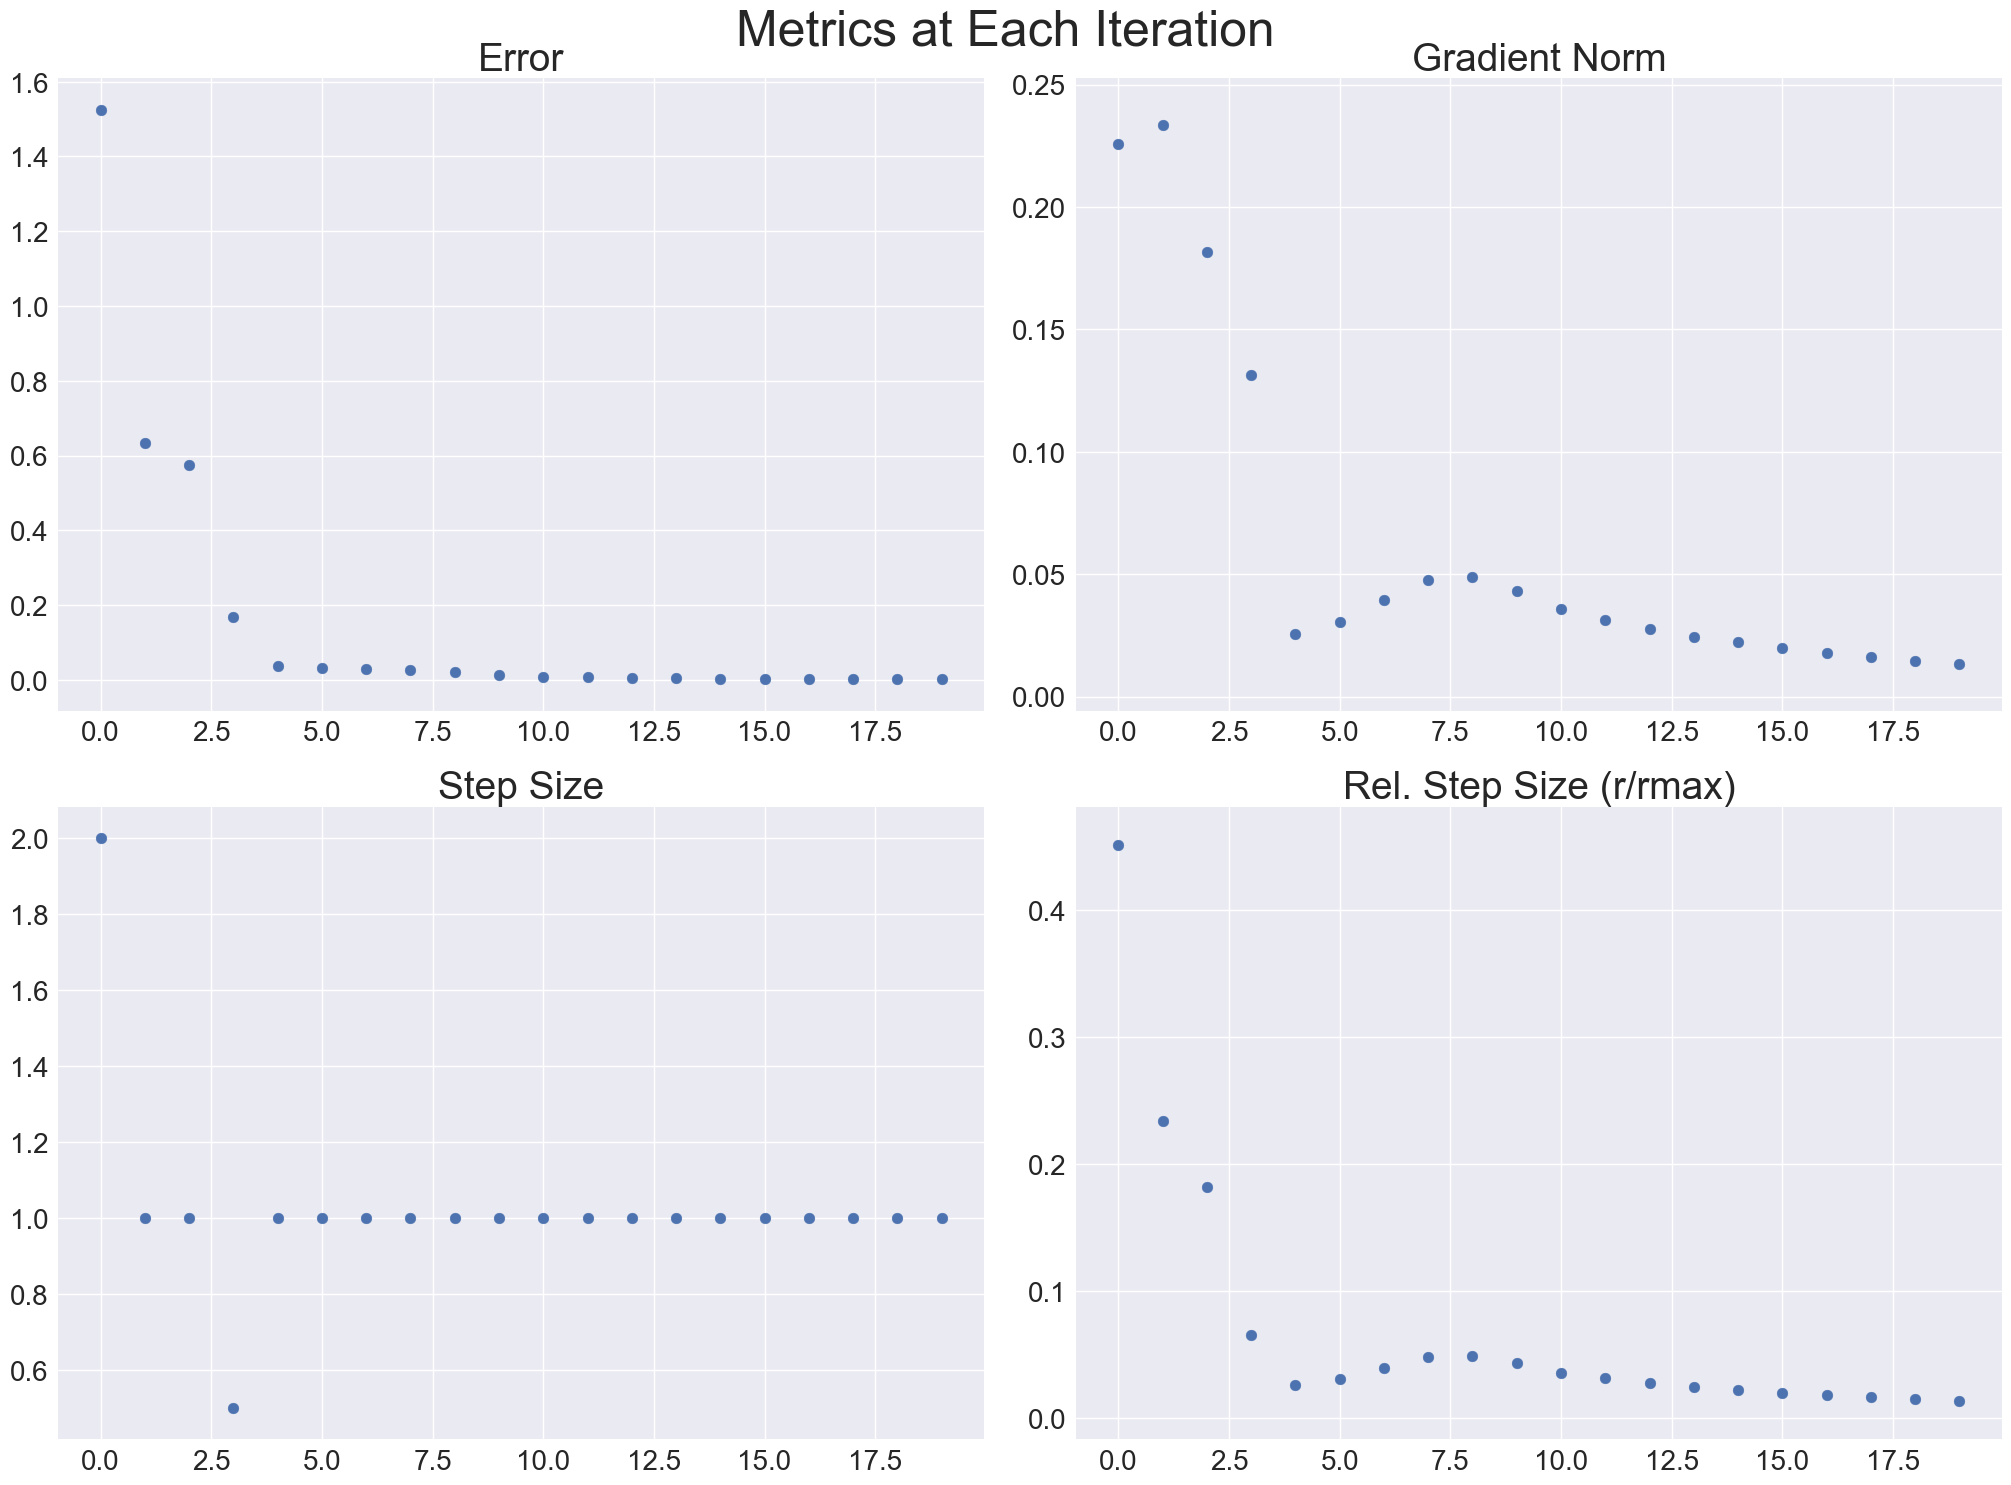

In [645]:
plot_training_metrics(data)

### Ex 2.) Animals Dataset

The next test case is a subset of the animals dataset is from UCI ML repository https://archive.ics.uci.edu/ml/datasets/zoo. It contains 17 features indicating various animal attributes. Ideally the hyperbolic distances of the embedding reflect the qualitative similarities of the animal classes. The input dissimilarity is the euclidean distances between observations in the dataset.  

In [703]:
zoo = pd.read_csv('zoo.data', header=None)
animals = ['hare', 'goat', 'octopus', 'wolf', 'chicken', 'tuna', 'lobster', 'cheetah', 
           'dove', 'opossum', 'raccoon', 'crow', 'sparrow']
animals_data = zoo.loc[zoo[0].apply(lambda x: x in animals), ]
animals_name = animals_data[0]
animals_data = animals_data.loc[:, 1:]
animals_name = np.array(animals_name)
zoo.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


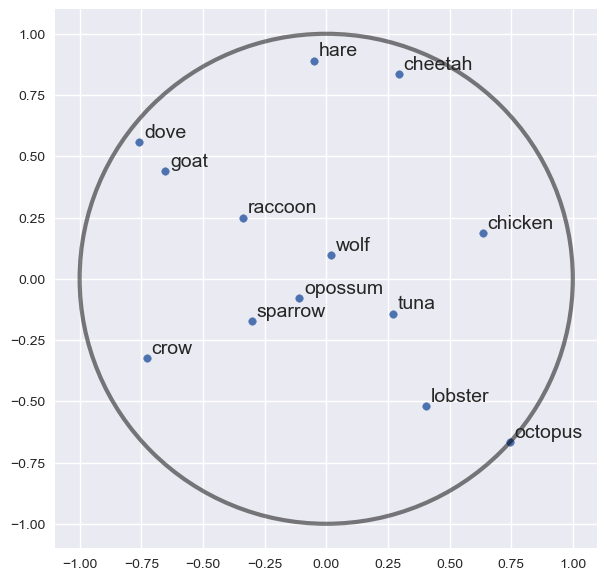

In [702]:
hmds = HyperMDS()
animals_emb = hmds.fit_transform(animals_data, max_epochs=20)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = animals_emb[:,0]
y = animals_emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(animals_emb[:40])):
    ax.text(x[i]+0.02, y[i]+0.02, animals_name[i], size=14)
plt.show();

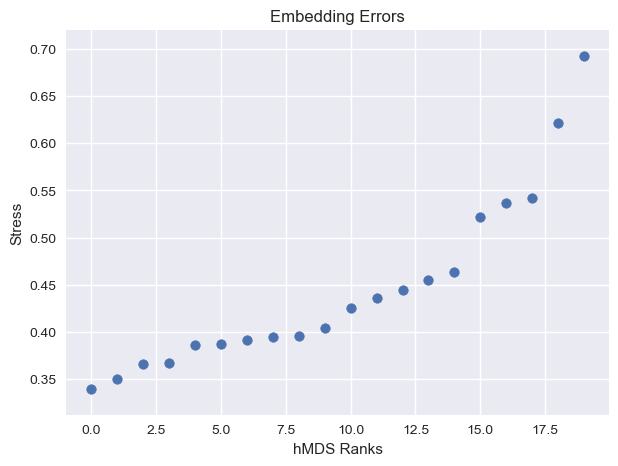

Min Error:  0.34007828224933334
Mean Error:  0.44606741757500473
Std. Deviation of Error:  0.09091046848579099


In [649]:
data = animals_data
hmds = HyperMDS()
plot_errors(hmds, data)

### Ex 3.) Iris Data

Finally, we apply hyperbolic MDS to the iris data with input dissimilarity matrix as the euclidean distances between the 150 iris data observations that have numerical features. With three distinct classes in the iris data, we can evaluate whether hyperbolic MDS clusters similar classes together.

In [754]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data
hmds = HyperMDS(alpha=2.5)
iris_emb = hmds.fit_transform(iris_data, max_epochs=30)
print('Sammon Stress: ', sammon_stress(iris_emb, hmds.dissimilarity_matrix, alpha=2.5))

Sammon Stress:  0.6945679992493006


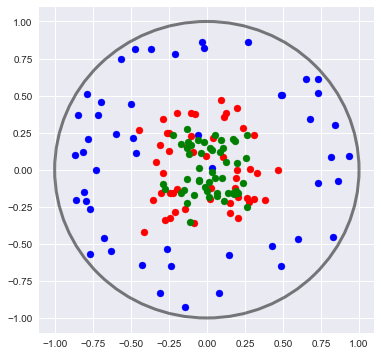

In [755]:
y = iris.target
X = iris_emb
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
ax.scatter(X[(y==0), 0], X[(y==0), 1], c='blue')
ax.scatter(X[(y==1), 0], X[(y==1), 1], c='red');
ax.scatter(X[(y==2), 0], X[(y==2), 1], c='green');

Min Error:  0.9984321773529241
Mean Error:  1.2111977273895493
Std. Deviation of Error:  0.15942741358621845


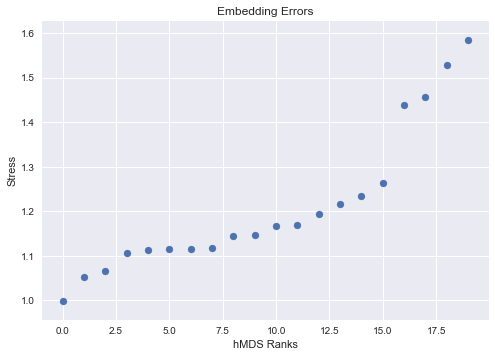

In [536]:
hmds = HyperMDS()
plot_errors(hmds, iris_data, num_rounds=20)

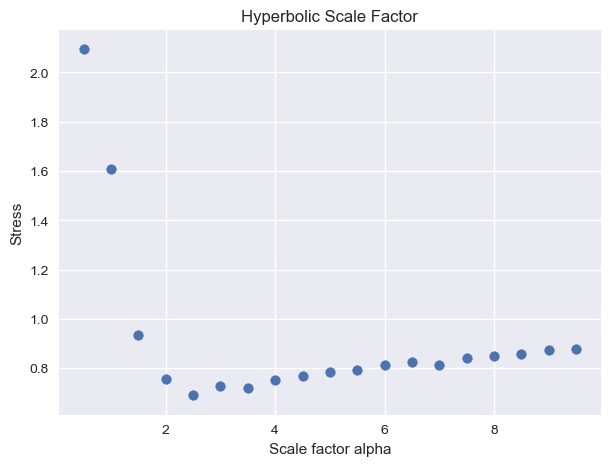

In [712]:
hmds = HyperMDS()
plot_alpha(hmds, iris_data)

In [744]:
from sklearn.manifold import MDS
model = MDS()
flat_emb = model.fit_transform(iris_data)
model.stress_

243.34603150321527

In [745]:
distances = euclidean_distances(flat_emb)
dissimilarity_matrix = euclidean_distances(iris_data)
embedding = flat_emb
stress = 0
scale = 0
n = embedding.shape[0]
for i in range(n):
    for j in range(i+1, n):
        if dissimilarity_matrix[i][j] != 0:
            delta_ij = dissimilarity_matrix[i][j]
            d_ij = distances[i][j]
            scale += delta_ij
            stress += (d_ij - delta_ij)**2 / delta_ij
stress / scale

0.007446366949016129

## Conclusion

In comparison to the results presented in [1], the results I obtained for the simple 7 point sample was quite close to the embedding error and the general trends apparent in the training metrics. On the iris dataset, it seems I obtained a similar optimal scaling factor, but the embedding errors in [1] were significantly better, around 0.4 compared to my best result of ~0.68. There are many ways to potentially test different parameters and optimize this implementation, especially concerning optimizing the time complexity, which wasn't of significant concern to me here compared to building a basic functioning implementation. <br>
<br>
A few interesting areas to explore would be more extensive comparisons to euclidean MDS embeddings and applying hyperbolic MDS to hierarchical datasets potentially related to clustering.

In [756]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()

## Resources

**[1]**. A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk. arXiv:1105.5332, 2011.<br>
**[2]**. H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space. Jörg Walter. Information Systems, Elsevier, 29(4):273-292, 2004.<br>
**[3]** De Sa, C., Gu, A., Ré, C., and Sala, F. Representation tradeoffs for hyperbolic embeddings. arXiv preprint arXiv:1804.03329, 2018.